# Algorytmy macierzowe - mnożenie macierzy rzadkich

*Wykonanie: Adrianna Łysik, Maksymilian Wojnar*

# Problem nr 2

**Mnożenie macierzy w formacie CSC oraz macierzy gęstej.**

Treść zadania:

1. Informacje o rozmiarach swoich macierzy $A$ i $B$ (w jaki sposób zostały one wygenerowane skryptem mass matrix).
2. Proszę narysować macierz $A$, $B$ oraz $C = A \times B$ używając `spy(A)`, `spy(B)` i `spy(A*B)`.
3. Proszę zmierzyć czas mnożenia macierzy $A \times B$ używając swojego programu z Zadania 1.
4. Proszę przekonwertować macierz $A$ do stosownego formatu rzadkiego.
5. Proszę umieścić i opisać kod użyty do konwersji.
6. Bardzo proszę napisać mnożenie macierzy o możliwie najmniejszym koszcie.
7. Proszę umieścić i opisać kod użyty do mnożenia przekonwertowanych macierzy.
8. Proszę zmierzyć czas mnożenia przekonwertownych macierzy $A \times B$.

Importy, ustawienia wyświetlania oraz wczytanie macierzy:

In [1]:
from time import perf_counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (15, 10)

# Ad 1, 2

In [2]:
matrix_A = pd.read_csv('matrix_A.csv', header=None, index_col=None).to_numpy()
matrix_B = pd.read_csv('matrix_B.csv', header=None, index_col=None).to_numpy()
max_size = min(len(matrix_A), len(matrix_B))

matrix_A = matrix_A[:max_size, :max_size]
matrix_B = matrix_B[:max_size, :max_size]

Macierz $A$ jest fragmentem macierzy wygenerowanym metodą `massmatrix(2, 6, 4, 4)` powielonym $(5,5)$ krotnie.

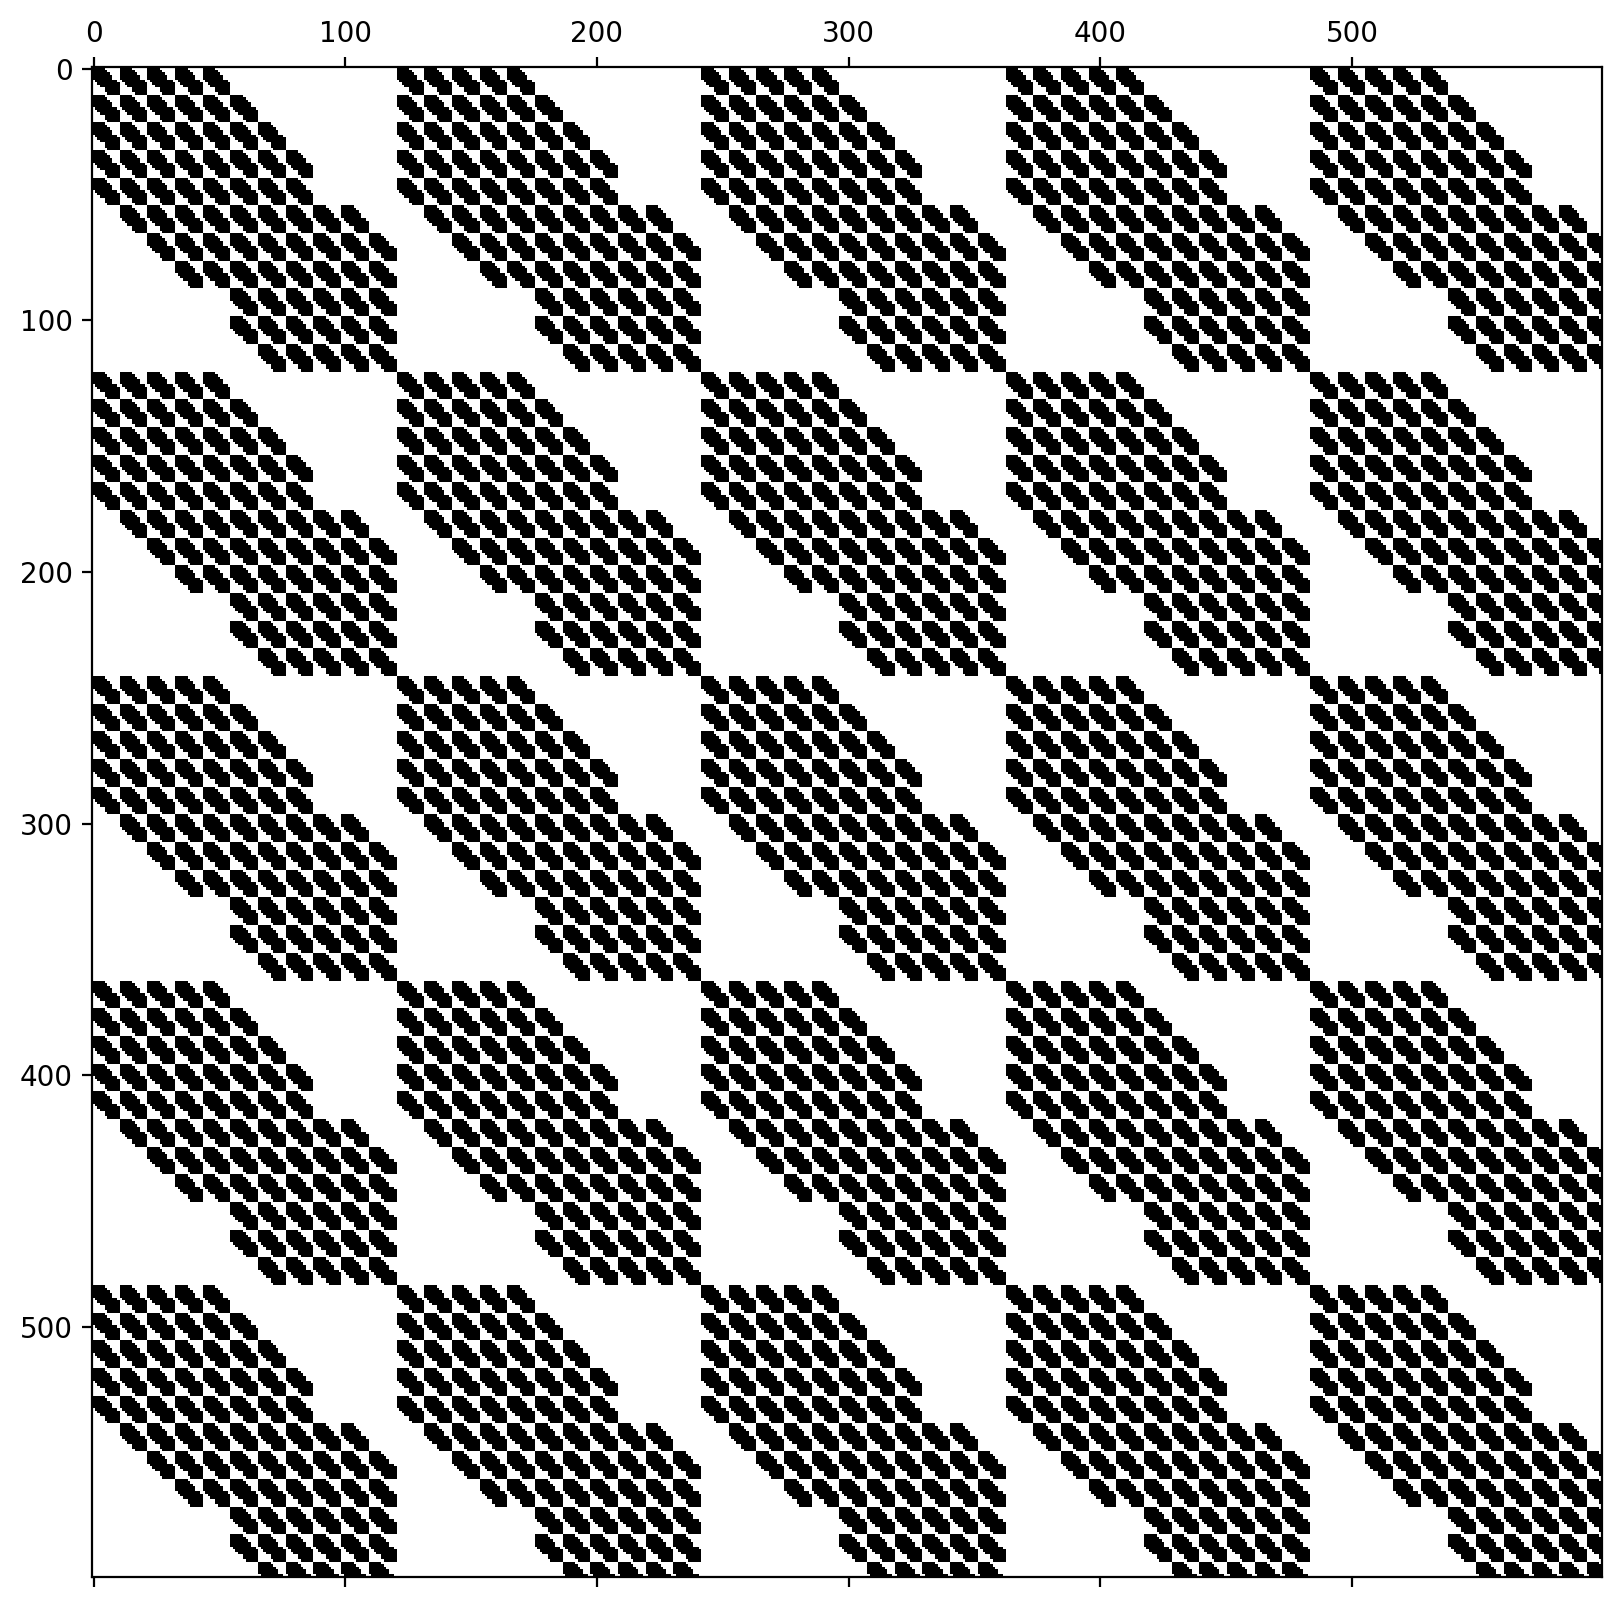

In [3]:
plt.spy(matrix_A)
plt.show()

Macierz $B$ jest fragmentem macierzy wygenerowanym metodą `massmatrix(2, 6, 2, 2)` powielonym $(6, 6)$ krotnie.

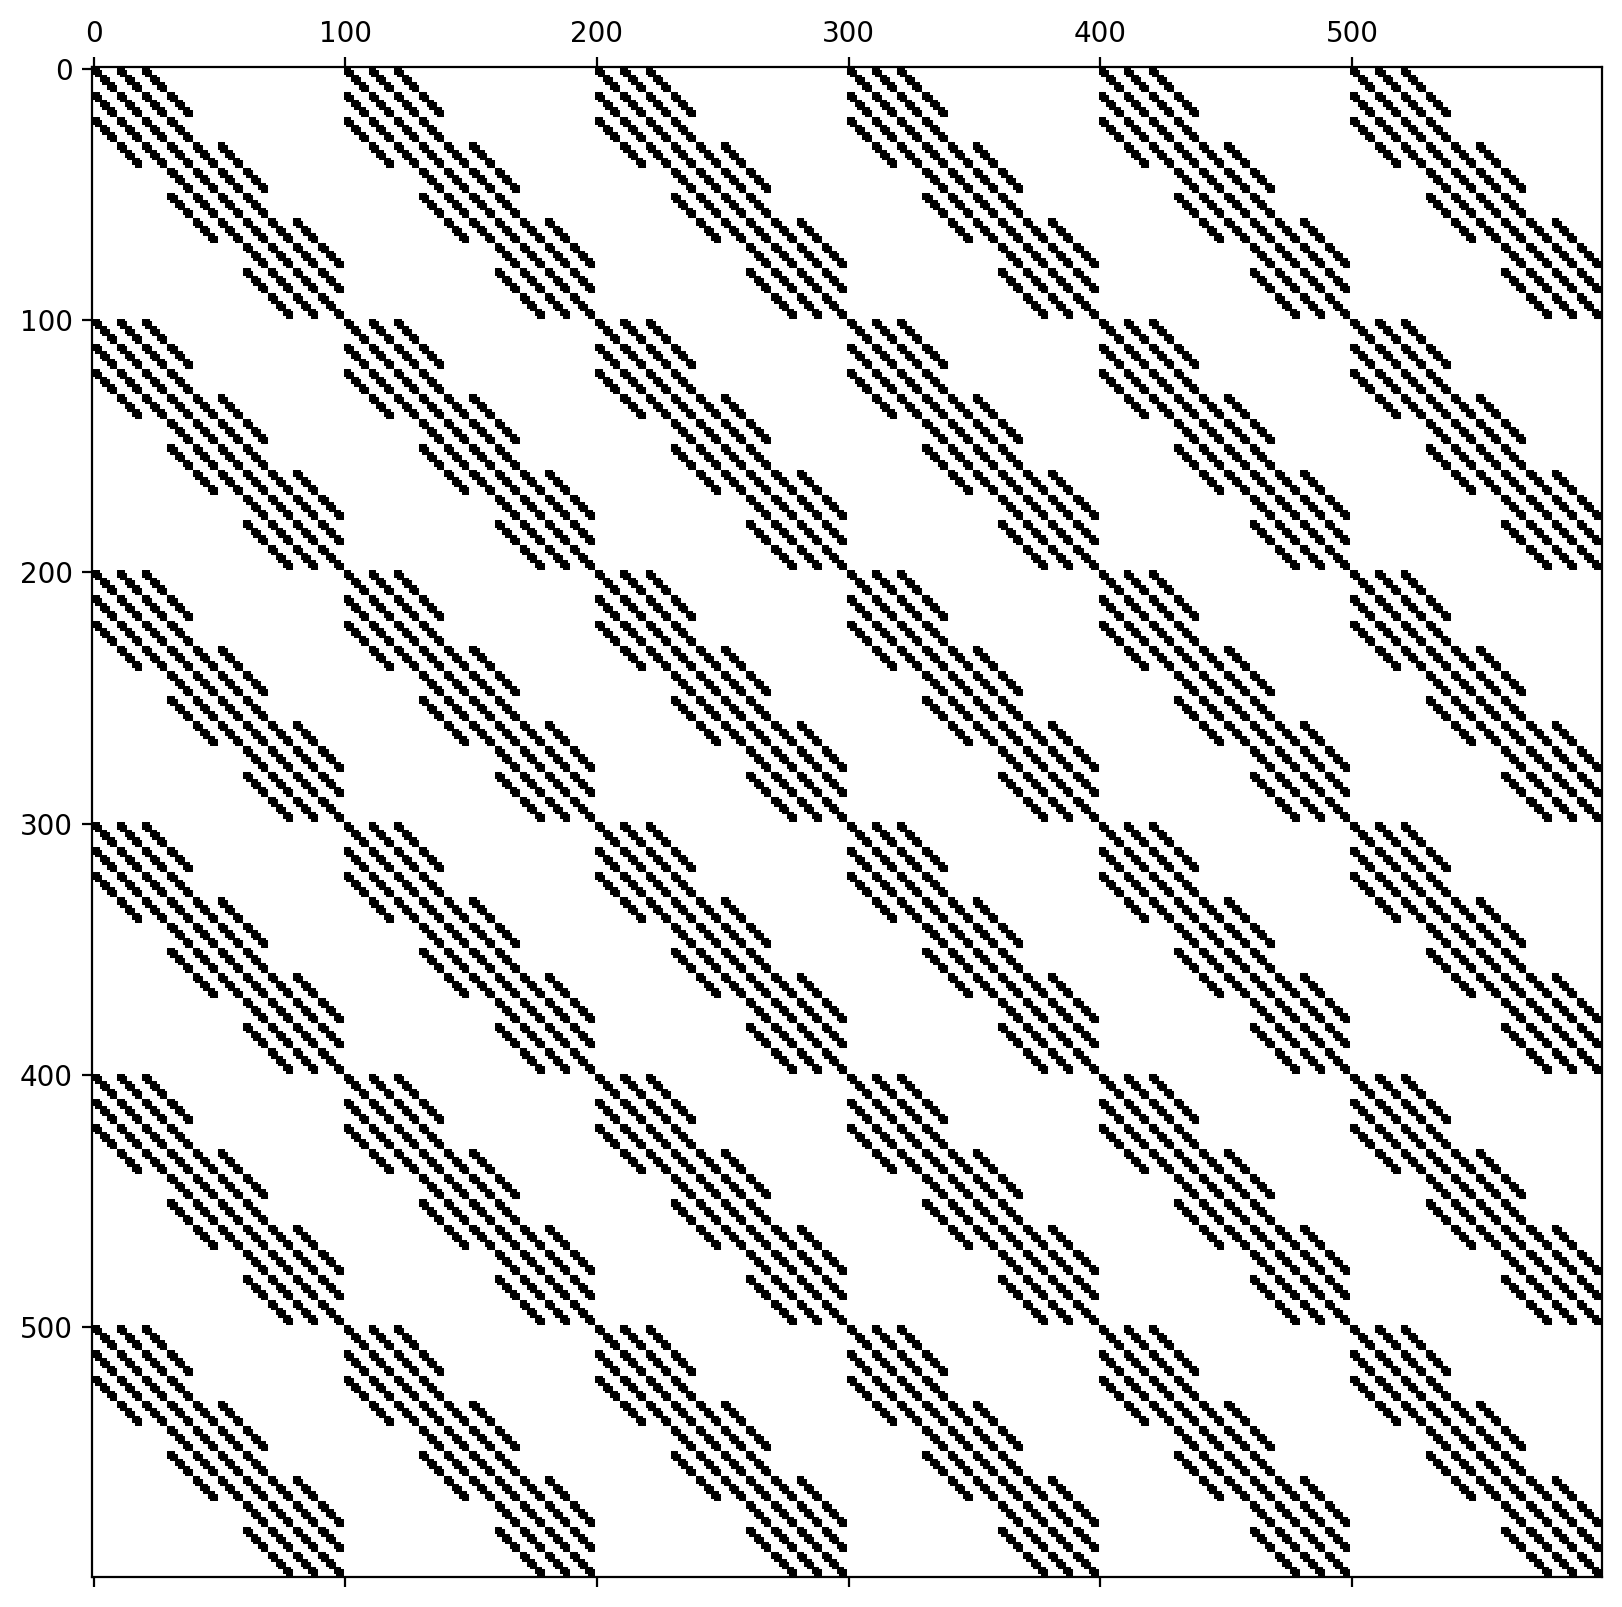

In [4]:
plt.spy(matrix_B)
plt.show()

Macierz $C = A \times B$ jest macierzą gęstą o wszystkich wartościach niezerowych.

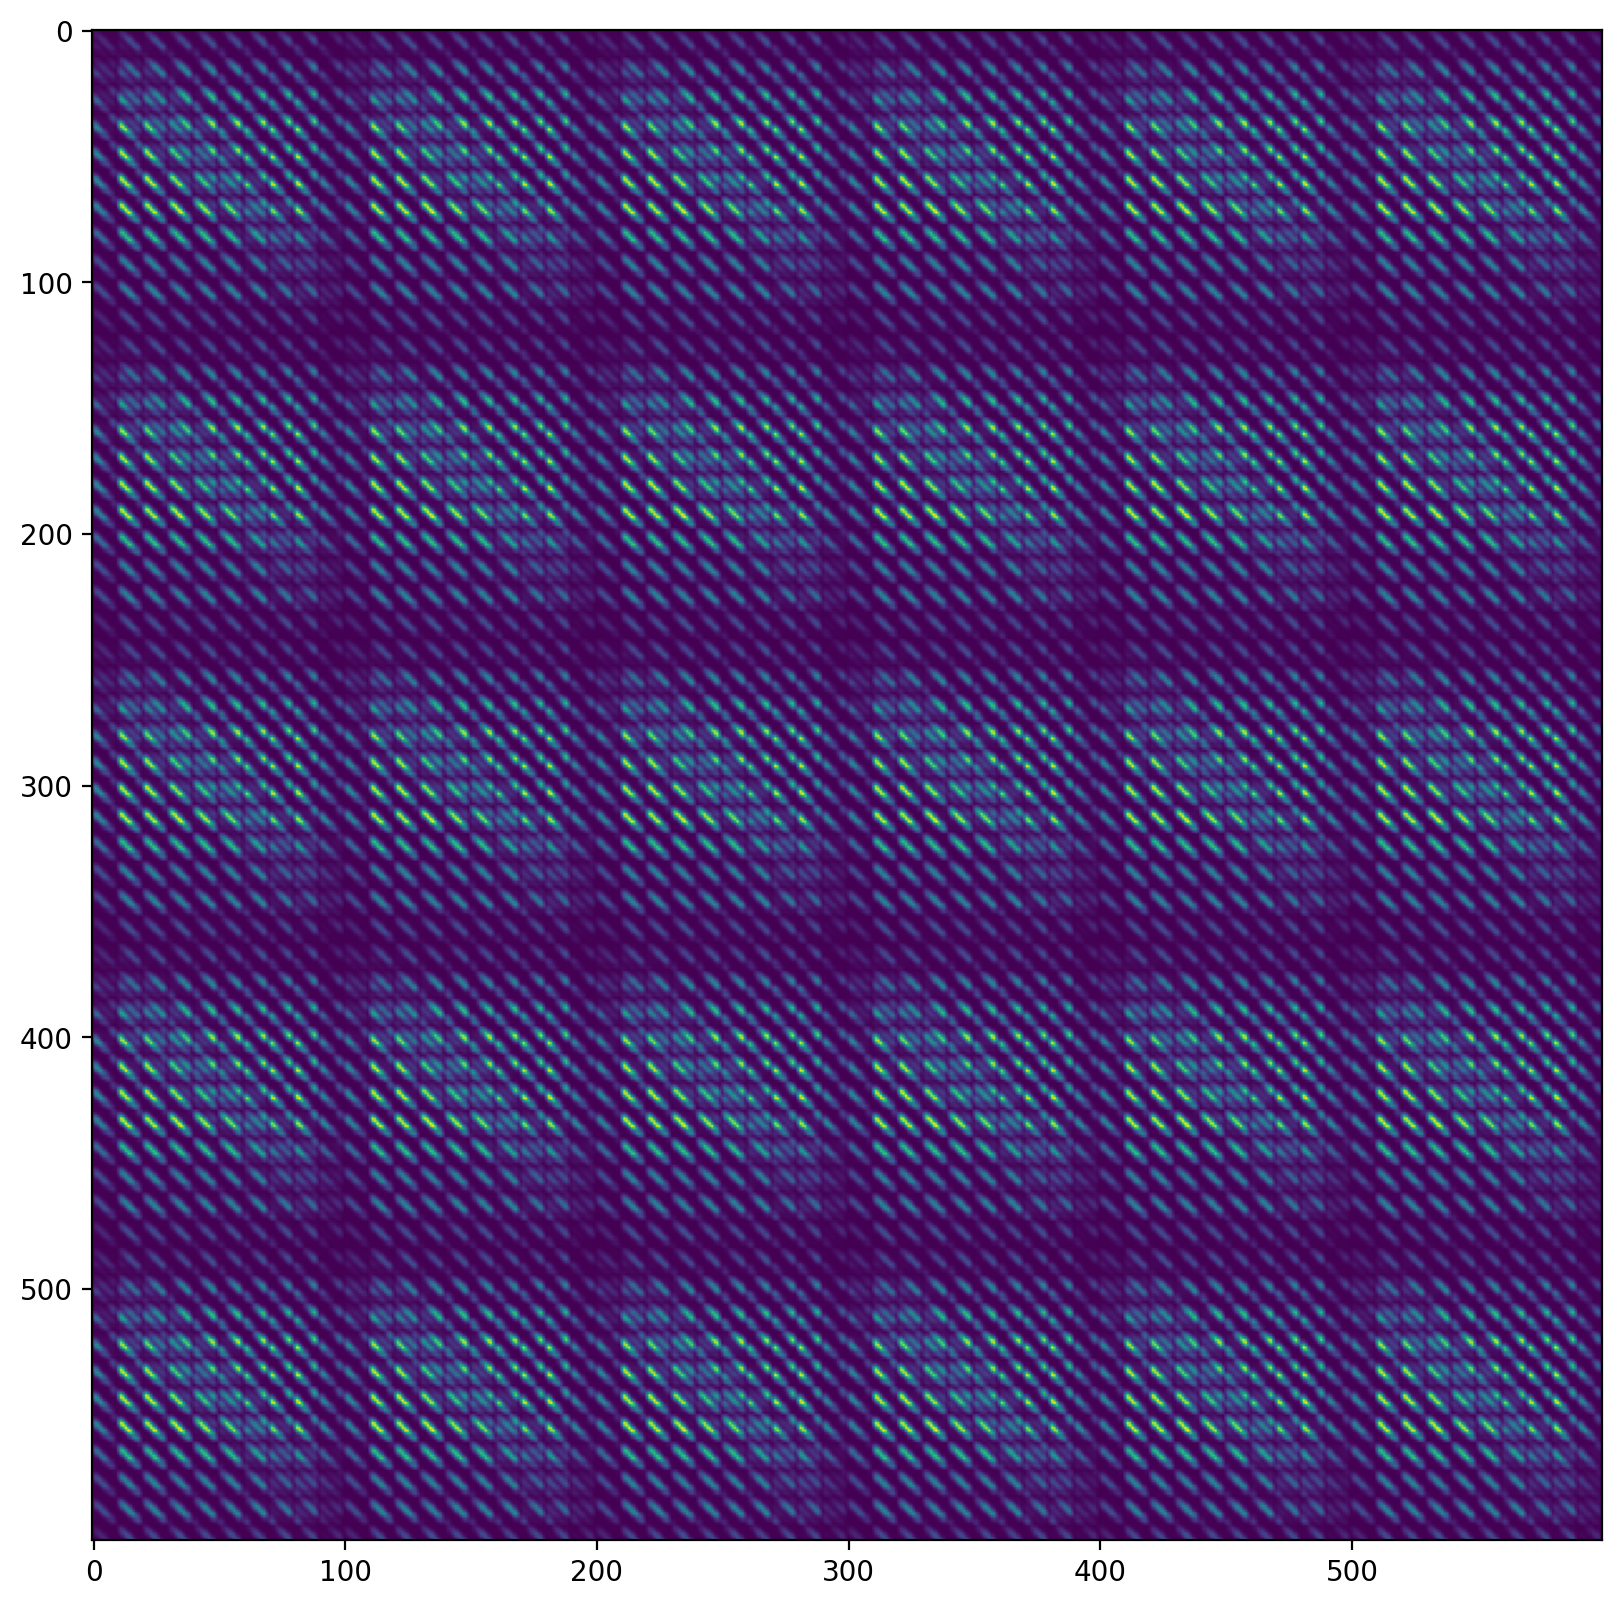

In [5]:
plt.imshow(matrix_A @ matrix_B)
plt.show()

# Ad 3

Aby efektywnie pomnożyć macierz w formacie CSC przez macierz gęstą, należy użyć jednej z permutacji indeksów: $kij, kji, jki$. Wybór innych wariantów mógłby spowodować znaczne spowolnienie mnożenia, gdyż wymagałoby to przechodzenia przez macierz rzadką wierszami. Takie przejście jest bardzo nieefektywne dla macierzy w formacie CSC.

Na początek mierzymy czasy mnożenia dwóch macierzy gęstych o rozmiarach $50 \times 50, 100 \times 100, \ldots, 600 \times 600$ z podanami wyżej permutacjami indeksów.

In [6]:
matrix_sizes = np.arange(50, min(600, max_size) + 1, 50)
permutations = ['jki', 'kij', 'kji']
dense_results = {perm: np.zeros(len(matrix_sizes)) for perm in permutations}

for idx, size in enumerate(matrix_sizes):
    A = matrix_A[:size, :size]
    B = matrix_B[:size, :size]
    times = {}

    C = np.zeros((size, size))
    start = perf_counter()

    for j in range(size):
        for k in range(size):
            for i in range(size):
                C[i][j] += A[i][k] * B[k][j]

    dense_results['jki'][idx] = perf_counter() - start
    C = np.zeros((size, size))
    start = perf_counter()

    for k in range(size):
        for i in range(size):
            for j in range(size):
                C[i][j] += A[i][k] * B[k][j]

    dense_results['kij'][idx] = perf_counter() - start
    C = np.zeros((size, size))
    start = perf_counter()

    for k in range(size):
        for j in range(size):
            for i in range(size):
                C[i][j] += A[i][k] * B[k][j]

    dense_results['kji'][idx] = perf_counter() - start

Oto wyniki dla macierzy o rozmiarach $600 \times 600$ i kolejnościach pętli $jki, kij, kji$:

In [7]:
pd.DataFrame([[perm, times[-1]] for perm, times in dense_results.items()], columns=['Kolejność pętli', 'Czas mnożenia [s]'])

,Kolejność pętli,Czas mnożenia [s]
0,jki,90.885775
1,kij,90.740899
2,kji,91.045184


# Ad 4, 5

Konwersja macierzy gęstej do macierzy rzadkiej w formacie CSC:

In [6]:
epsilon = 1e-14


class CSCMatrix:
    def __init__(self, matrix):
        if matrix is not None:
            self.dtype = matrix.dtype   # typ elementów macierzy
            self.shape = matrix.shape   # wymiary macierzy
            self.vals = []     # wartości elementów macierzy
            self.irn = []      # numery wierszy poszczególnych elementów
            self.colptr = [0]  # lista z indeksami kolejnych kolumn w vals, irn
            self.nnz = 0       # liczba elementów niezerowych macierzy

            self.from_dense(matrix)

    # konwersja do postaci rzadkiej
    def from_dense(self, matrix):
        for j in range(matrix.shape[1]):   # macierz jest przeglądana kolumnami
            for i in range(matrix.shape[0]):
                if not np.abs(matrix[i, j]) < epsilon: # jeśli element jest niezerowy
                    self.vals.append(matrix[i, j])  # zapisujemy jego wartość,
                    self.irn.append(i)              # numer wiersza
                    self.nnz += 1                   # i zwiększamy liczbę el. niezerowych

            self.colptr.append(self.nnz)  # po przejściu przez kolumnę zapisujemy indeks końca tej kolumny

    # generator wartości i numerów wierszy w danej kolumnie
    def get_col(self, col):
        col_start = self.colptr[col]          # indeks początku kolumny
        col_end = self.colptr[col + 1]        # indeks końca kolumny
        rows = self.irn[col_start:col_end]    # numery wierszy elementów
        vals = self.vals[col_start:col_end]   # wartości elementów

        for row, val in zip(rows, vals):
            yield row, val

    # konwersja do postaci gęstej
    def to_dense(self):
        dense = np.zeros(self.shape, dtype=self.dtype)

        for j in range(self.shape[1]):
            for row, val in self.get_col(j):
                dense[row, j] = val

        return dense

# Ad 6, 7

Funkcje mnożące macierz w formacie CSC przez macierz gęstą w różnych konfiguracjach indeksów:

In [10]:
def sparse_mul_jki(csc, matrix):
    result = np.zeros(csc.shape)    # macierz wynikowa (gęsta)
    n = csc.shape[0]                # rozmiar macierzy wejściowych

    for j in range(n):
        for k in range(n):
            for i, val in csc.get_col(k):    # przejście po wartościach z kolumn macierzy CSC
                result[i, j] += val * matrix[k, j]

    return result

Pozostałe metody są analogiczne do powyższej:

In [11]:
def sparse_mul_kij(csc, matrix):
    result = np.zeros(csc.shape)
    n = csc.shape[0]

    for k in range(n):
        for i, val in csc.get_col(k):
            for j in range(n):
                result[i, j] += val * matrix[k, j]

    return result

In [12]:
def sparse_mul_kji(csc, matrix):
    result = np.zeros(csc.shape)
    n = csc.shape[0]

    for k in range(n):
        for j in range(n):
            for i, val in csc.get_col(k):
                result[i, j] += val * matrix[k, j]

    return result

# Ad 8

Pomiar czasu mnożenia macierzy rzadkiej i gęstej w takich samych rozmiarach, co poprzednio:

In [13]:
sparse_results = {perm: np.zeros(len(matrix_sizes)) for perm in permutations}

for idx, size in enumerate(matrix_sizes):
    A = matrix_A[:size, :size]
    B = matrix_B[:size, :size]
    A_csc = CSCMatrix(A)
    times = {}

    start = perf_counter()
    C = sparse_mul_jki(A_csc, B)
    sparse_results['jki'][idx] = perf_counter() - start
    assert np.all(np.abs(C - A @ B) < epsilon)

    start = perf_counter()
    C = sparse_mul_kij(A_csc, B)
    sparse_results['kij'][idx] = perf_counter() - start
    assert np.all(np.abs(C - A @ B) < epsilon)

    start = perf_counter()
    C = sparse_mul_kji(A_csc, B)
    sparse_results['kji'][idx] = perf_counter() - start
    assert np.all(np.abs(C - A @ B) < epsilon)

Wyniki dla macierzy o rozmiarach $600 \times 600$:

In [14]:
pd.DataFrame([[perm, times[-1]] for perm, times in sparse_results.items()], columns=['Kolejność pętli', 'Czas mnożenia [s]'])

,Kolejność pętli,Czas mnożenia [s]
0,jki,22.476529
1,kij,18.682072
2,kji,22.491158


Porównanie czasów mnożenia na wykresie:

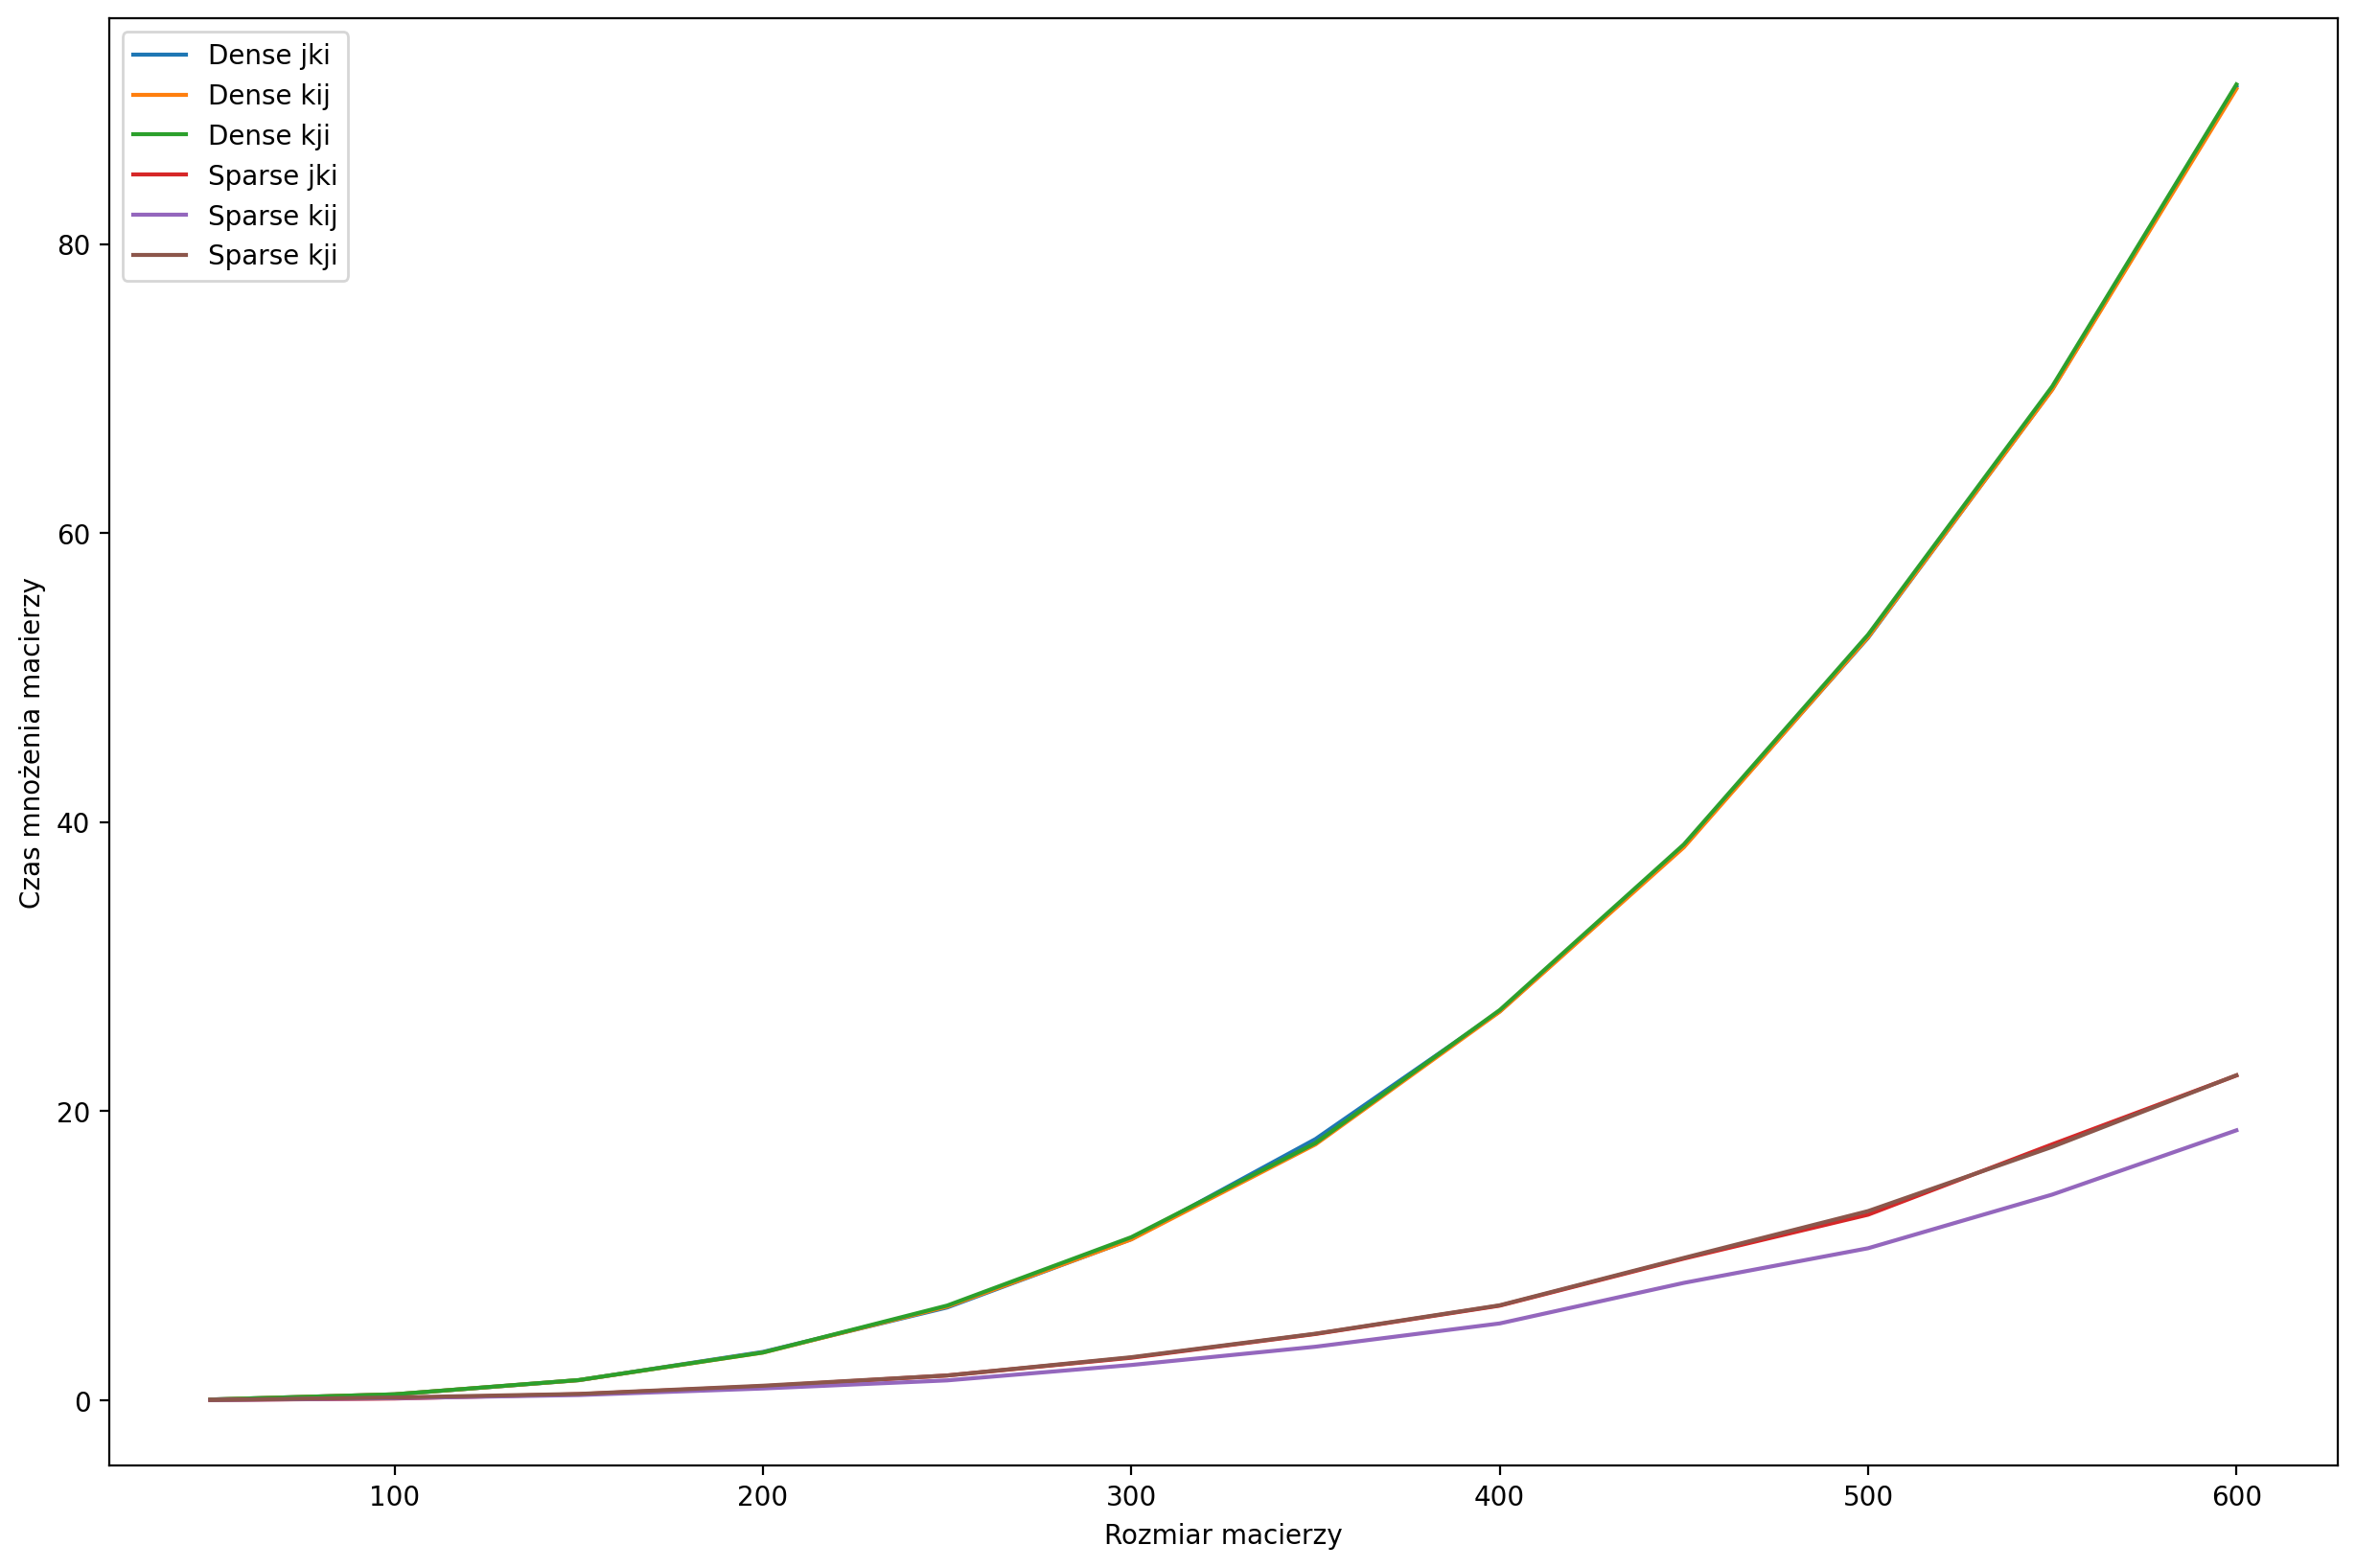

In [16]:
for perm, times in dense_results.items():
    plt.plot(matrix_sizes, times, label=f'Dense {perm}')

for perm, times in sparse_results.items():
    plt.plot(matrix_sizes, times, label=f'Sparse {perm}')

plt.legend()
plt.ylabel('Czas mnożenia macierzy')
plt.xlabel('Rozmiar macierzy')
plt.show()

Wykres z czasami mnożenia dla macierzy rzadkiej:

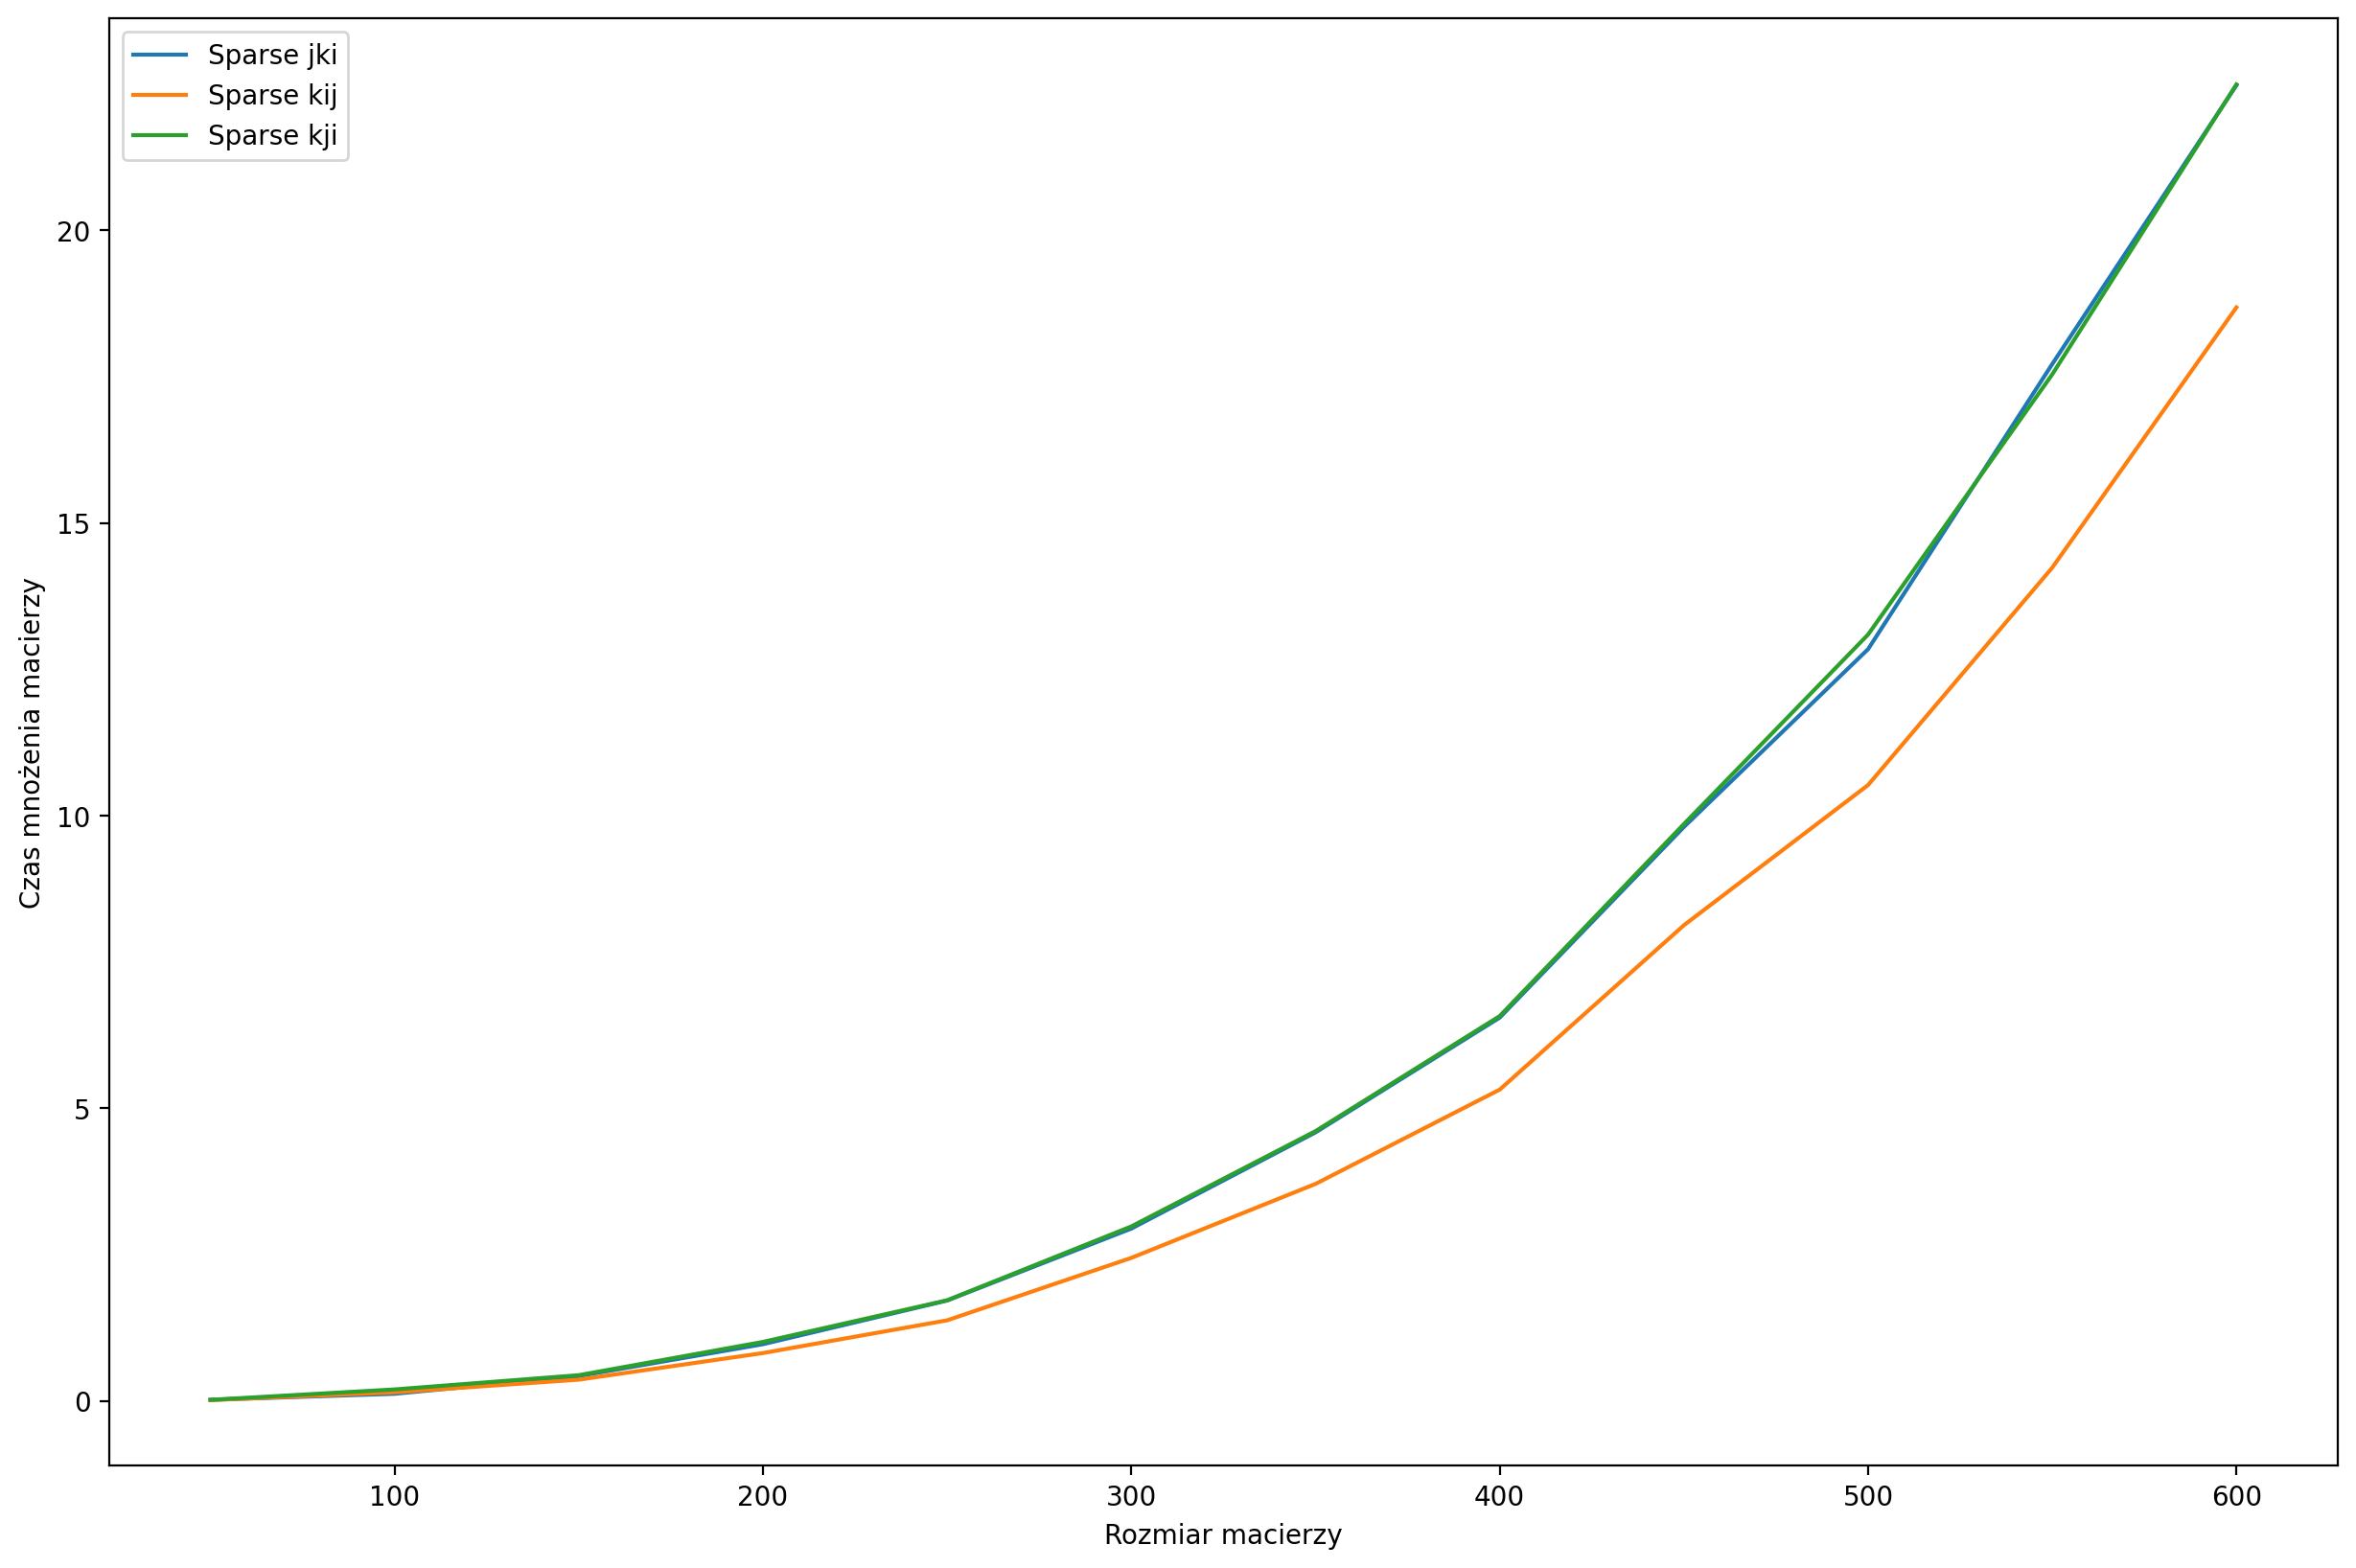

In [17]:
for perm, times in sparse_results.items():
    plt.plot(matrix_sizes, times, label=f'Sparse {perm}')

plt.legend()
plt.ylabel('Czas mnożenia macierzy')
plt.xlabel('Rozmiar macierzy')
plt.show()

Zastosowanie jednej z macierzy w formacie rzadkim dało około 4.5x przyspieszenie. Najszybsza okazała się wersja z permutacją indeksów $kij$.

# Dodatkowe testy

## Mnożenie $B \times A$ dla $B$ w formacie CSC

Postanowiliśmy przetestować również mnożenie macierzy $B$ w formacie CSC przez gęstą $A$, gdyż $B$ jest znacznie rzadsza od macierzy $A$.

In [18]:
print(f'Stosunek niezerowych elementów A: {CSCMatrix(matrix_A).nnz / (matrix_A.shape[0] * matrix_A.shape[1]):.2f}')

Stosunek niezerowych elementów A: 0.41


In [19]:
print(f'Stosunek niezerowych elementów B: {CSCMatrix(matrix_B).nnz / (matrix_B.shape[0] * matrix_B.shape[1]):.2f}')

Stosunek niezerowych elementów B: 0.16


Sprawdziliśmy czasy mnożenia dla macierzy do wielkości $300 \times 300$. Tym razem przyspieszenie okazało się jeszcze większe, bo około 10-12x.

In [20]:
pd.DataFrame([[perm, times[300]] for perm, times in ba_results.items()], columns=['Kolejność pętli', 'Czas mnożenia [s]'])

,Kolejność pętli,Czas mnożenia [s]
0,jki,1.155195
1,kij,0.911270
2,kji,1.167998


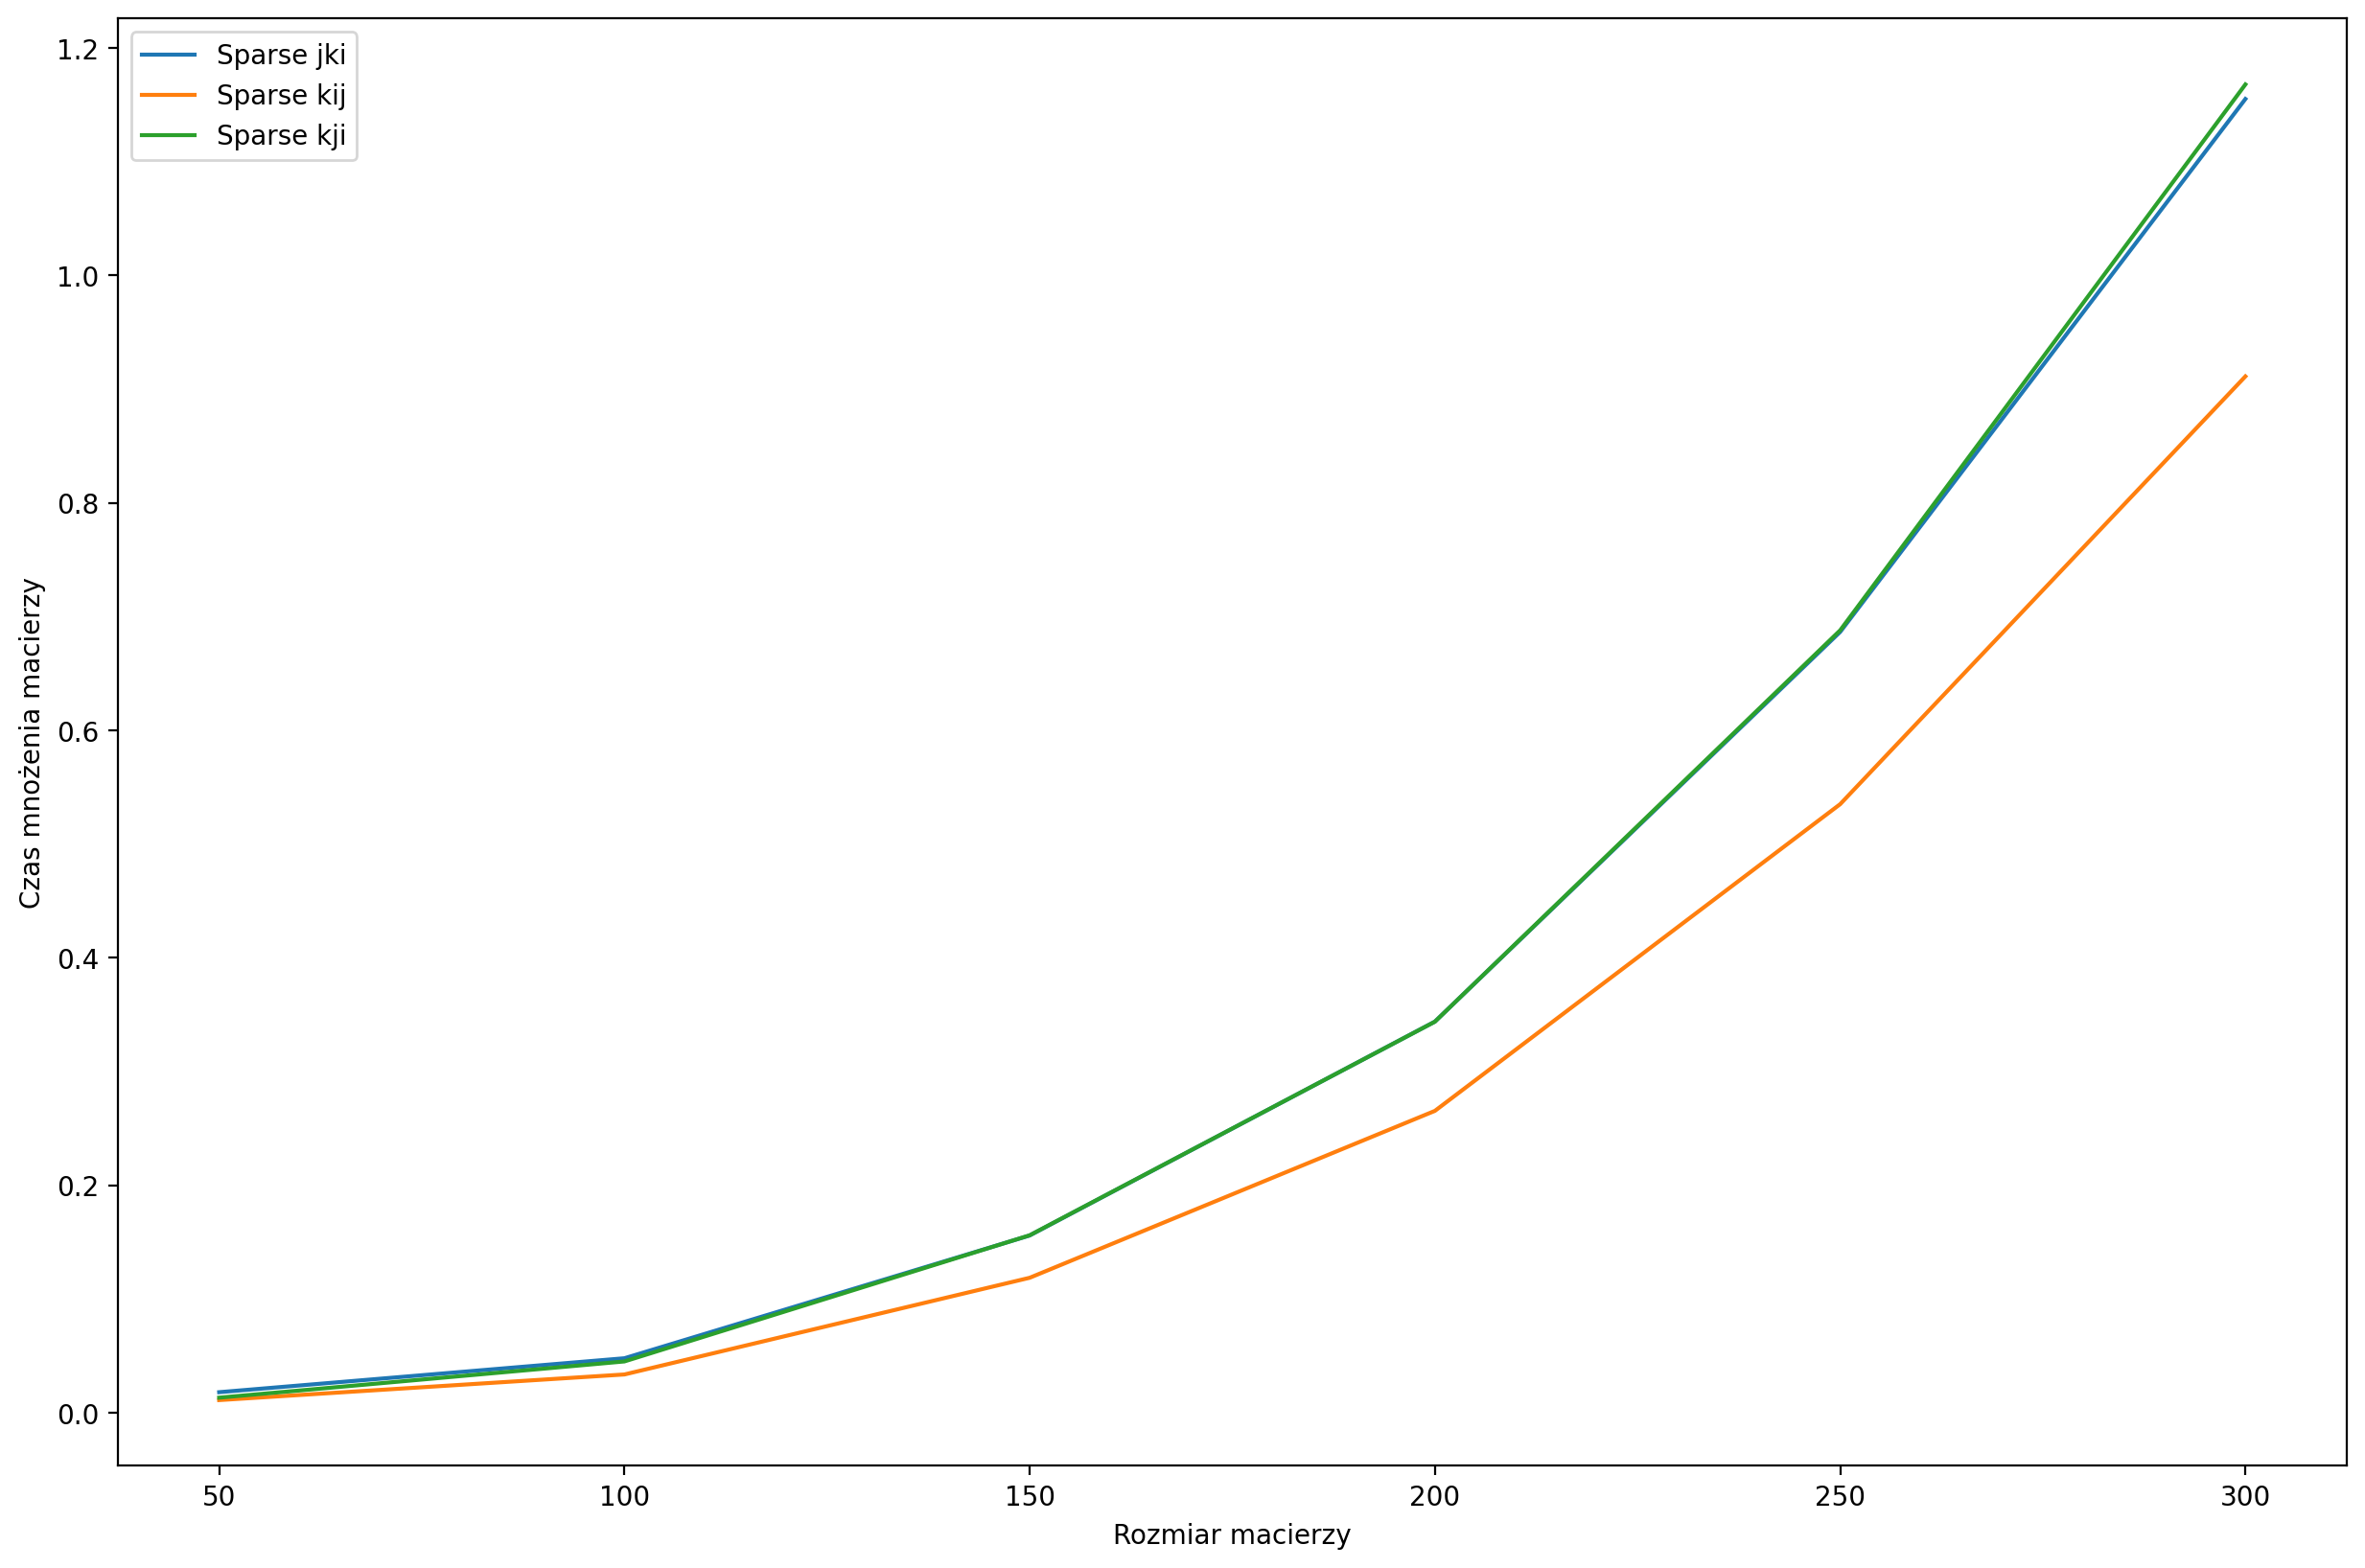

In [22]:
for perm, times in ba_results.items():
    plt.plot(matrix_sizes, times, label=f'Sparse {perm}')

plt.legend()
plt.ylabel('Czas mnożenia macierzy')
plt.xlabel('Rozmiar macierzy')
plt.show()

## Optymalizacja sprzętowa

Powyższe wyniki zostały uzyskane na laptopie z proceseorem Apple M1.

Dla porównania przedstawiamy wyniki dla macierzy do rozmiaru $300 \times 300$ na sprzęcie z procesorem Intel Core i5 7300HQ.

### Procesor Apple M1

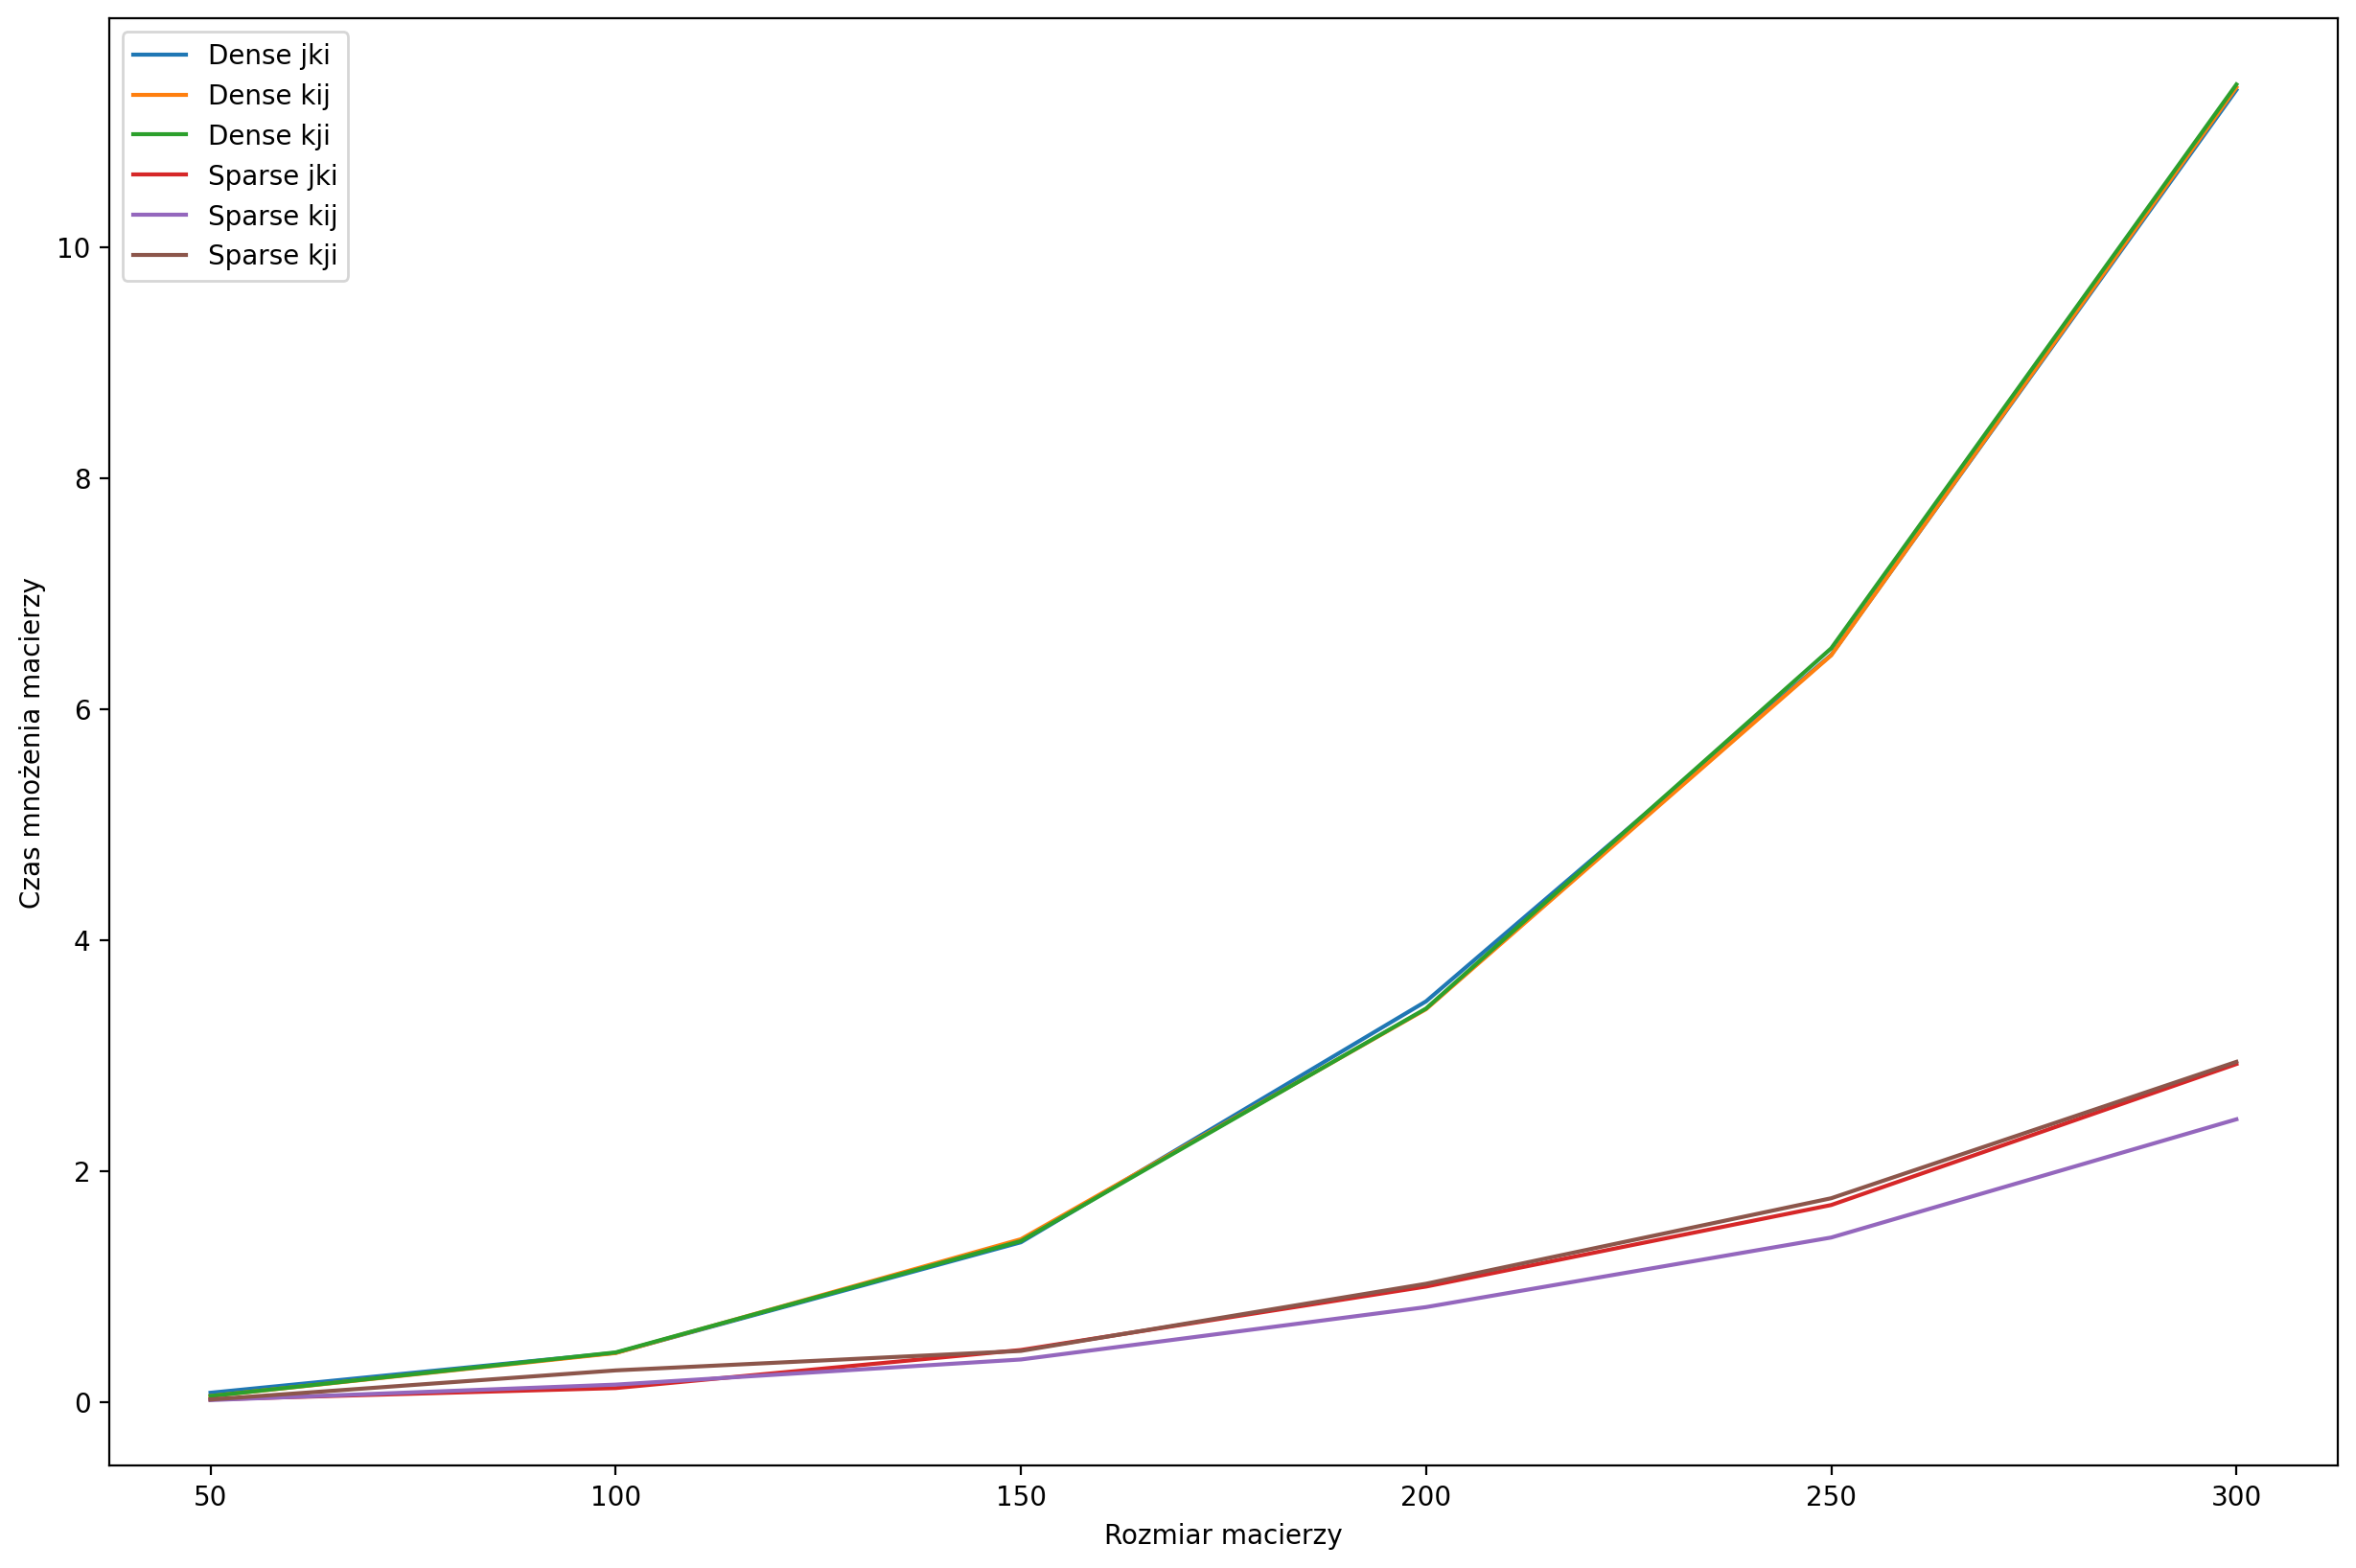

In [23]:
for perm, times in m1_dense_results.items():
    plt.plot(matrix_sizes, times, label=f'Dense {perm}')

for perm, times in m1_dense_results.items():
    plt.plot(matrix_sizes, times, label=f'Sparse {perm}')

plt.legend()
plt.ylabel('Czas mnożenia macierzy')
plt.xlabel('Rozmiar macierzy')
plt.show()

### Procesor Intel Core i5 7300HQ

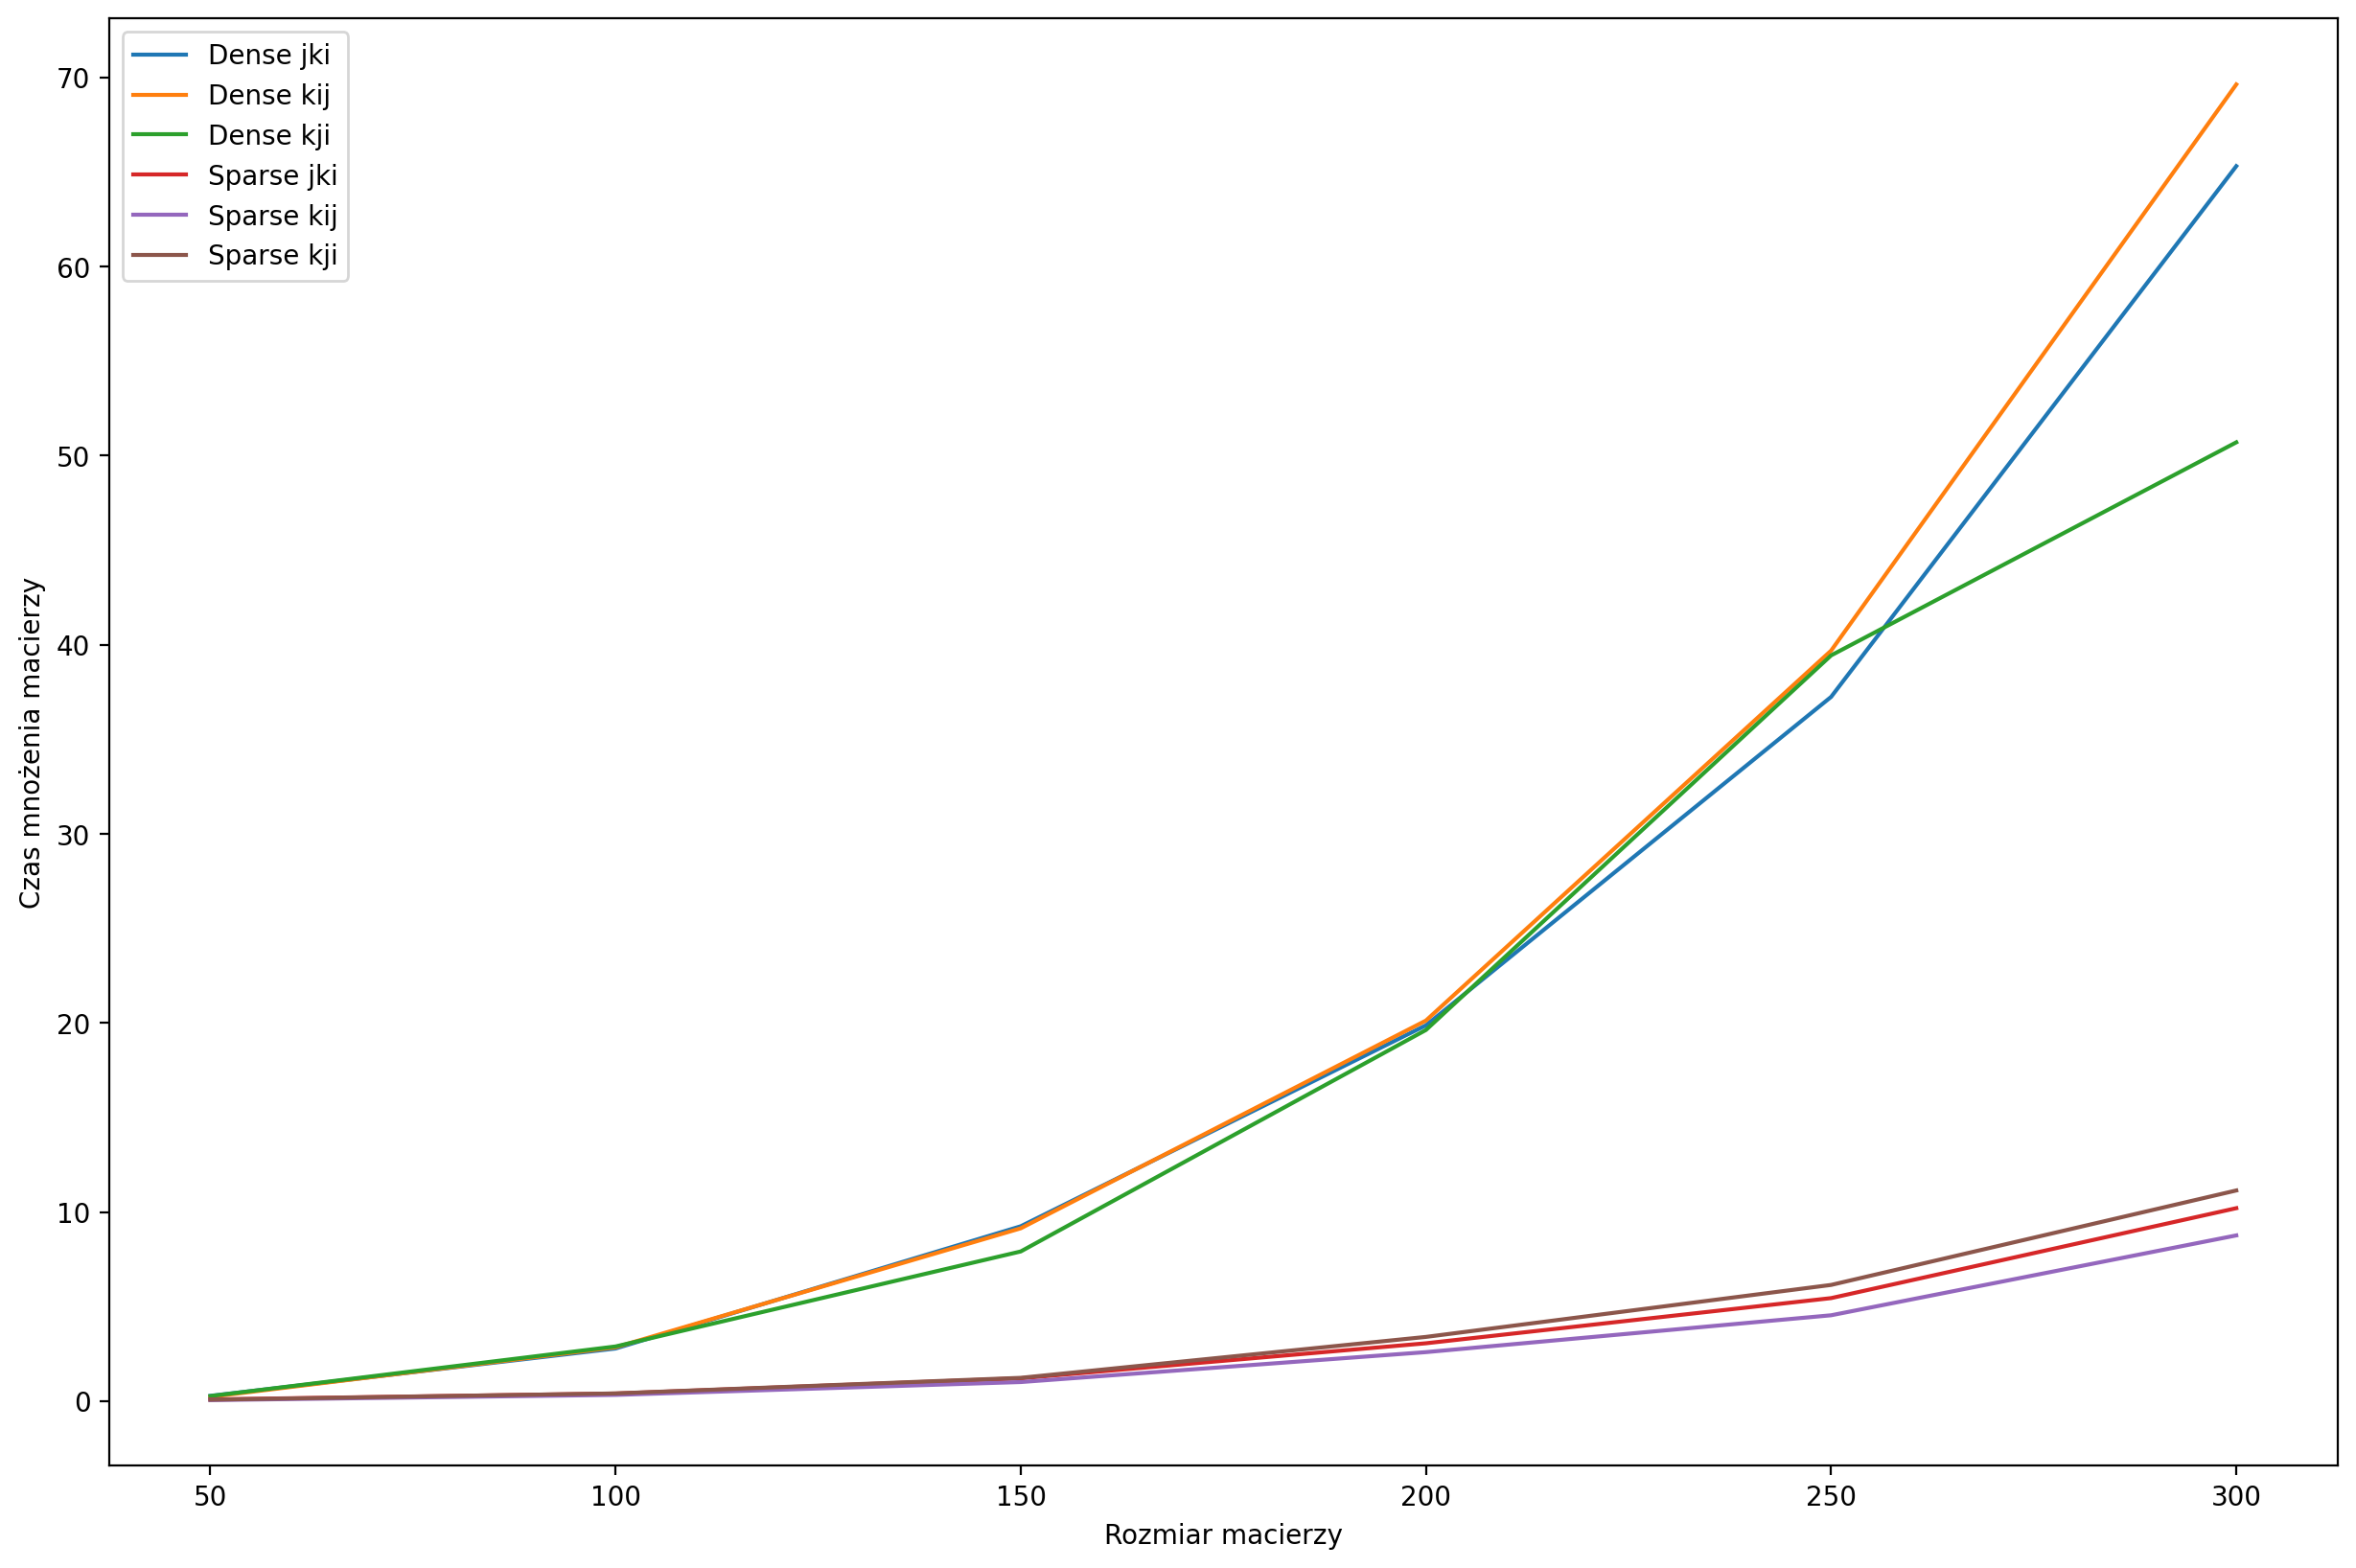

In [24]:
for perm, times in i5_dense_results.items():
    plt.plot(matrix_sizes, times, label=f'Dense {perm}')

for perm, times in i5_dense_results.items():
    plt.plot(matrix_sizes, times, label=f'Sparse {perm}')

plt.legend()
plt.ylabel('Czas mnożenia macierzy')
plt.xlabel('Rozmiar macierzy')
plt.show()

Okazało się, że procesor Apple M1 jest około 3-6x szybszy, niż Intel Core i5 7300 HQ. Może to wynikać z konstrukcji procesora, typu wykonywanych operacji lub optymalizacji oprogramowania.

# Wnioski

 - Użycie rzadkiego mnożenia daje znaczne (kilku lub kilkunastrokrotne) przyspieszenie przy korzystaniu z rzadkich macierzy.
 - Najbardziej optymalna kolejność pętli przy mnożeniu macierzy w formacie CSC to $kij$. Metody, w których najbardziej wewnętrzna pętla przechodziła przez kolumny macierzy rzadkiej uzyskały nieco gorsze resultaty - prawdopodobnie przejście przez cały wiersz macierzy gęstej jest szybsze, niż iterowanie po wartościach kolumny macierzy CSC.
 - Im rzadsza macierz, tym większe przyspieszenie jesteśmy w stanie uzyskać, ponieważ pomijamy w algorytmie więcej elementów macierzy.
 - Szybki procesor i odpowiednie optymalizacje mogą znacznie przyspieszyć działanie programu; procesor Apple M1 uzyskał zaskakująco dobre wyniki w naszych testach.